In [44]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from functools import partial
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

import os
import pandas as pd
import numpy as np

import requests
from tqdm import tqdm

import tarfile
import os
import shutil
import io

In [3]:
#download the data using the below code into your local setup
url = 'http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz'
file_path = 'BreaKHis_v1.tar.gz'

response = requests.get(url, stream=True)

if response.status_code == 200:


  total_size = int(response.headers.get('content-length', 0))
  progress_bar = tqdm(total=total_size, unit='B', unit_scale=True)

  with open(file_path, 'wb') as file:
      for chunk in response.iter_content(chunk_size=1024):
          if chunk:
              file.write(chunk)
              progress_bar.update(len(chunk))

  progress_bar.close()
  print('File downloaded successfully.')
else:

  print('Failed to download the file.')


100%|██████████| 4.27G/4.27G [08:37<00:00, 8.26MB/s]

File downloaded successfully.


In [4]:
# get all the 400x png files into a folder

# Define the tar file
tar_file_path = 'BreaKHis_v1.tar.gz'

# Define the directory to store the extracted files
output_dir = 'extracted_images_400x'
os.makedirs(output_dir, exist_ok=True)

# Open the tar file
tar = tarfile.open(tar_file_path)

# Iterate over each member in the tar file
for member in tar.getmembers():
    if '400X' in member.name and member.name.endswith('.png'):
        # Use extractfile() to get a file-like object for the file data
        file_data = tar.extractfile(member)

        if file_data is not None:
            # Get the base filename (without directories)
            base_filename = os.path.basename(member.name)
            # Define the target file path in the output_dir
            target_path = os.path.join(output_dir, base_filename)

            # Write the file data to the new file
            with open(target_path, 'wb') as f:
                shutil.copyfileobj(file_data, f)

# Close the tar file
tar.close()


In [5]:
!ls extracted_images_400x | head -n 20


SOB_B_A-14-22549AB-400-001.png
SOB_B_A-14-22549AB-400-002.png
SOB_B_A-14-22549AB-400-003.png
SOB_B_A-14-22549AB-400-004.png
SOB_B_A-14-22549AB-400-005.png
SOB_B_A-14-22549AB-400-006.png
SOB_B_A-14-22549AB-400-007.png
SOB_B_A-14-22549AB-400-008.png
SOB_B_A-14-22549AB-400-009.png
SOB_B_A-14-22549AB-400-010.png
SOB_B_A-14-22549AB-400-011.png
SOB_B_A-14-22549AB-400-012.png
SOB_B_A-14-22549AB-400-013.png
SOB_B_A-14-22549AB-400-014.png
SOB_B_A-14-22549AB-400-015.png
SOB_B_A-14-22549AB-400-016.png
SOB_B_A-14-22549AB-400-017.png
SOB_B_A-14-22549AB-400-018.png
SOB_B_A-14-22549AB-400-019.png
SOB_B_A-14-22549AB-400-020.png


In [6]:
#creating a dataframe that has the patient id, file path, type

# Define the directory where the files are stored
directory = 'extracted_images_400x'

# Get the list of file names
filenames = os.listdir(directory)

# Create a DataFrame from the file names
df = pd.DataFrame(filenames, columns=['filename'])

# Extract the type (M or B), patient ID and image ID from the filename
df['type'] = df['filename'].str.split('_', expand=True)[1]
df['patient_ID'] = df['filename'].str.split('-', expand=True)[2]

# Display the DataFrame
df


,filename,type,patient_ID
0,SOB_B_TA-14-3411F-400-003.png,B,3411F
1,SOB_M_DC-14-11520-400-015.png,M,11520
2,SOB_B_A-14-22549AB-400-026.png,B,22549AB
3,SOB_M_MC-14-18842-400-004.png,M,18842
4,SOB_M_MC-14-12773-400-002.png,M,12773
...,...,...,...
1815,SOB_M_LC-14-15570C-400-004.png,M,15570C
1816,SOB_B_F-14-23222AB-400-009.png,B,23222AB
1817,SOB_M_DC-14-2773-400-036.png,M,2773
1818,SOB_M_LC-14-12204-400-043.png,M,12204


In [7]:

# Get a list of unique patient IDs for each type
malignant_ids = df[df['type'] == 'M']['patient_ID'].unique()
benign_ids = df[df['type'] == 'B']['patient_ID'].unique()

# Function to split patient IDs into train, validation, and test
def split_ids(ids):
    np.random.shuffle(ids)
    train_size = int(len(ids) * 0.8)
    val_size = int(len(ids) * 0.1)
    train_ids = ids[:train_size]
    val_ids = ids[train_size:train_size + val_size]
    test_ids = ids[train_size + val_size:]
    return train_ids, val_ids, test_ids

# Split patient IDs for each type
train_m_ids, val_m_ids, test_m_ids = split_ids(malignant_ids)
train_b_ids, val_b_ids, test_b_ids = split_ids(benign_ids)

# Concatenate train, validation, and test patient IDs
train_patient_ids = np.concatenate([train_m_ids, train_b_ids])
val_patient_ids = np.concatenate([val_m_ids, val_b_ids])
test_patient_ids = np.concatenate([test_m_ids, test_b_ids])

# Get corresponding dataframes
train_df = df[df['patient_ID'].isin(train_patient_ids)]
val_df = df[df['patient_ID'].isin(val_patient_ids)]
test_df = df[df['patient_ID'].isin(test_patient_ids)]


In [8]:
print('file name is', 'train_df')
for column in train_df.columns:
    print(column, train_df[column].nunique())


print('file name is', 'val_df')
for column in val_df.columns:
    print(column, val_df[column].nunique())


print('file name is', 'test_df')
for column in test_df.columns:
    print(column, test_df[column].nunique())


file name is train_df
filename 1482
type 2
patient_ID 64
file name is val_df
filename 115
type 2
patient_ID 7
file name is test_df
filename 223
type 2
patient_ID 10


In [46]:
# Define image size and path
img_size = (700, 460)
batch_size = 32
directory = 'extracted_images_400x'

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=directory,
    x_col='filename',
    y_col='type',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=directory,
    x_col='filename',
    y_col='type',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle the validation data
)



Found 1482 validated image filenames belonging to 2 classes.
Found 115 validated image filenames belonging to 2 classes.


In [47]:
# Define the standard CNN model
n_filters = 12  # Base number of convolutional filters

In [48]:
def make_standard_classifier(n_outputs=1, dropout_rate=0.2):
    Conv2D = partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = partial(tf.keras.layers.Dense, activation='relu')

    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),
        Dropout(dropout_rate),  # Dropout layer here
        Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
        Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
        Dropout(dropout_rate),  # Dropout layer here
        Conv2D(filters=8*n_filters, kernel_size=3, strides=2),
        Dropout(dropout_rate),  # Dropout layer here
        Flatten(),
        Dense(512),
        Dropout(dropout_rate),  # Dropout layer here
        Dense(n_outputs, activation='sigmoid')
    ])
    return model

In [49]:
# Create the standard CNN model with dropout (dropout_rate=0.5)
standard_classifier = make_standard_classifier(dropout_rate=0.2)

In [50]:
# Compile the model
standard_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
# Define callbacks
early_stop = EarlyStopping(patience=5)
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1
lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model
history=standard_classifier.fit(train_generator, validation_data=val_generator, epochs=15, batch_size = 32, callbacks=[early_stop, lr_schedule])

Epoch 1/15
47/47 [==============================] - 137s 3s/step - loss: 1.2636 - accuracy: 0.7382 - val_loss: 0.6781 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/15
47/47 [==============================] - 132s 3s/step - loss: 0.4628 - accuracy: 0.8266 - val_loss: 0.6623 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/15
47/47 [==============================] - 133s 3s/step - loss: 0.4581 - accuracy: 0.8151 - val_loss: 0.6801 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/15
47/47 [==============================] - 133s 3s/step - loss: 0.3989 - accuracy: 0.8441 - val_loss: 0.5378 - val_accuracy: 0.6435 - lr: 0.0010
Epoch 5/15
47/47 [==============================] - 134s 3s/step - loss: 0.3684 - accuracy: 0.8576 - val_loss: 0.7591 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/15
47/47 [==============================] - 133s 3s/step - loss: 0.3355 - accuracy: 0.8650 - val_loss: 0.9406 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 7/15
47/47 [==============================] - 132s 3s/step - loss:

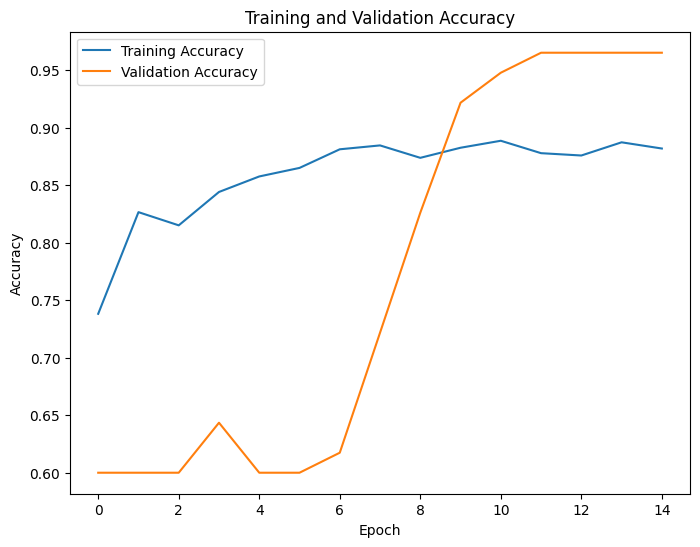

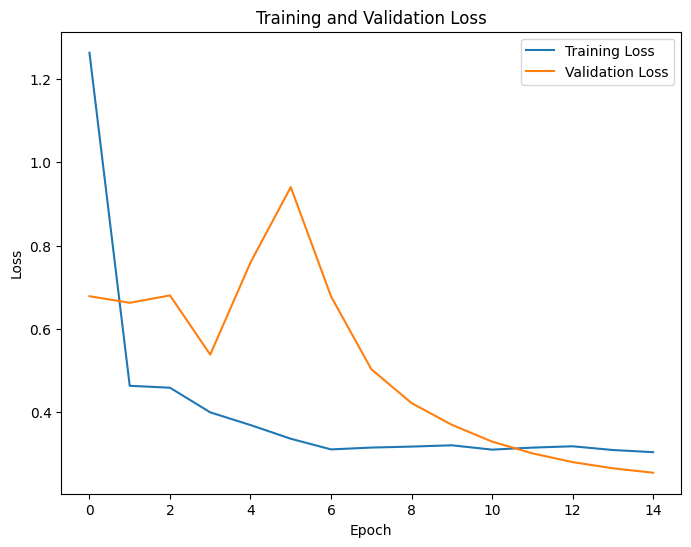

In [52]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [53]:
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=directory,
    x_col='filename',
    y_col='type',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False  # Set shuffle to False to maintain order
)




Found 223 validated image filenames belonging to 2 classes.


In [54]:
# Make predictions on the test data
y_pred_prob = standard_classifier.predict(test_generator)
y_pred = np.round(y_pred_prob).flatten()

# Get true labels from the test data
y_true = test_generator.labels

7/7 [==============================] - 5s 745ms/step


In [55]:
# Compute classification report
classification_rep = classification_report(y_true, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       103
           1       0.79      0.97      0.87       120

    accuracy                           0.84       223
   macro avg       0.87      0.83      0.84       223
weighted avg       0.87      0.84      0.84       223



In [57]:
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mtx)

Confusion Matrix:
[[ 71  32]
 [  3 117]]


In [58]:
# Compute ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9312


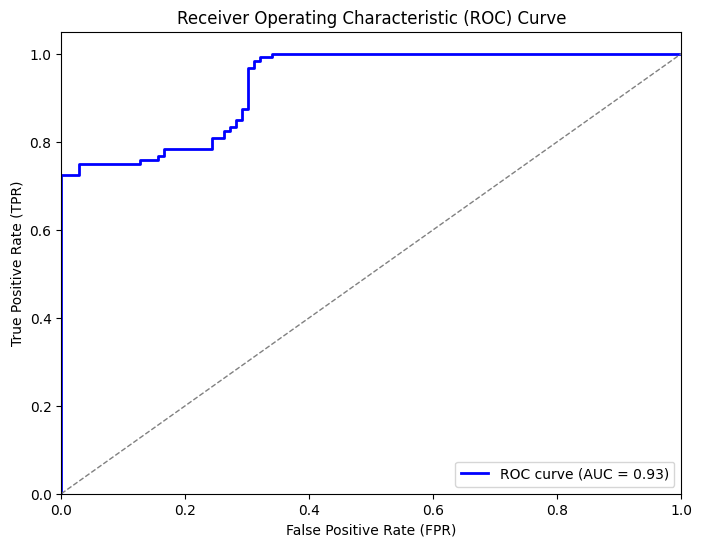

In [59]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [60]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [62]:
standard_classifier.save('/content/gdrive/My Drive/trained_model.h5') # Save the model on Google Drive for future predictions.

In [ ]:
from tensorflow.keras.models import load_model
from google.colab import drive

# Mount Google Drive
# drive.mount('/content/gdrive') Uncomment this line to load the model

# Load the model
# loaded_model = load_model('/content/gdrive/My Drive/trained_model.h5') Uncomment this line to load the model
